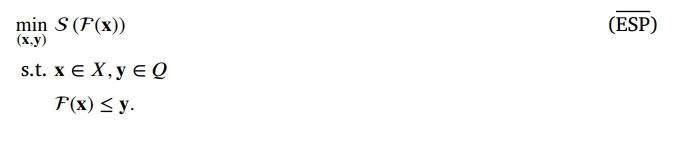

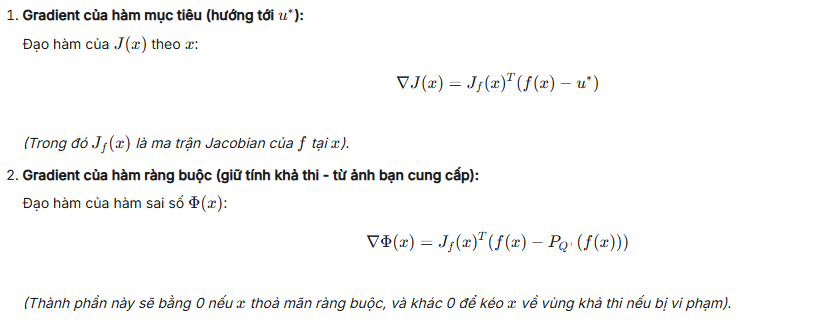

---

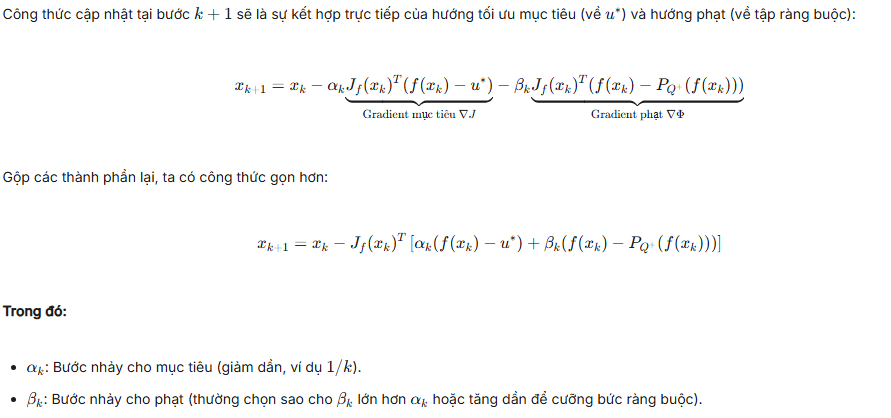

$\beta_k = \alpha_k * \gamma_k$

* Dãy hiệu chỉnh:...

In [1]:
import autograd.numpy as np
from autograd import jacobian
from scipy.optimize import Bounds
from project import Projection
from algorithm_CQ import CQ_split_acceptance
from problem import Problem
from prettytable import PrettyTable
from utils import visualize_complete_system

import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
# ==========================================
# 1. ĐỊNH NGHĨA BÀI TOÁN CỤ THỂ
# ==========================================

# Hàm f(x) = x
def f(x):
    return np.array([x[0], x[1]])

def jac_f_func(x):
    return np.eye(2)

# --- Tập C: Hình tròn tâm O, bán kính 2 ---
# x1^2 + x2^2 <= 4
def c1(x):
    return 4 - (x[0]**2 + x[1]**2)

cons_C = ({'type': 'ineq', 'fun': c1},)
bounds_x = None 
dim_x = 2

# --- Tập Q: Hình hộp [-3, -1] x [-3, -1] ---
def q_box_lower(y): return np.array([y[0] + 3, y[1] + 3])
def q_box_upper(y): return np.array([-1 - y[0], -1 - y[1]])
def q_plus_upper(t):
    return np.array([-1 - t[0], -1 - t[1]])



# Hàm dùng cho Projection Qplus (chỉ cần chặn trên của Q để xác định Q+)
# Q+ = {z | z <= y_max}, ở đây y_max = (-1, -1)
cons_Q = (
    {'type': 'ineq', 'fun': lambda y: np.concatenate([q_box_lower(y), q_box_upper(y)])},
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus_upper},
)
dim_y = 2

In [3]:
# ==========================================
# 2. KHỞI TẠO ĐỐI TƯỢNG VÀ GIẢI CẤP 1
# ==========================================

print("=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===")

# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

# Setup Problem
prob = Problem(
    f=[f], jac_f=[jac_f_func], C=[c1], Q=[], 
    dim_x=dim_x, dim_y=dim_y,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

# --- Điểm khởi tạo Phase 1 ---
x_init = np.array([2.0, 2.0]) # Trong C, nhưng vi phạm Q+

print("\n--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---")
# Chạy thuật toán CQ có sẵn của bạn
x_feasible, x_hist, f_hist, z_proj_hist = CQ_split_acceptance(
    f=prob.objective_func,
    jac_f=prob.jacobian,
    proj_C=prob.proj_C,
    proj_Qplus=prob.proj_Qplus,
    x0=x_init,
    gamma=0.5, # Learning rate cho CQ
    max_iter=50,
    tol=1e-4
)

print(f"-> Điểm khả thi tìm được sau Phase 1: {x_feasible}")

=== BẮT ĐẦU VÍ DỤ MINH HỌA ESP 2 CẤP ===

--- PHASE 1: TÌM ĐIỂM KHẢ THI (CQ ALGORITHM) ---
Khởi tạo: x0: [2. 2.]
Chiếu lên C được: x: [1.4142 1.4142]


 32%|███▏      | 16/50 [00:00<00:00, 345.70it/s]


Hội tụ tại vòng lặp 16
+----+------------------------+------------------------+------------+----------+----------+
| k  | x_new                  | y                      | z_proj     |   e_x    |   e_f    |
+----+------------------------+------------------------+------------+----------+----------+
| 0  | [1.414214, 1.414213]   | [1.414214, 1.414213]   | [-1., -1.] | 1.707107 | 3.414214 |
| 1  | [0.207107, 0.207107]   | [0.207107, 0.207107]   | [-1., -1.] | 0.853580 | 1.707107 |
| 2  | [-0.396464, -0.396467] | [-0.396464, -0.396467] | [-1., -1.] | 0.426764 | 0.853527 |
| 3  | [-0.698232, -0.698234] | [-0.698232, -0.698234] | [-1., -1.] | 0.213311 | 0.426763 |
| 4  | [-0.849067, -0.849066] | [-0.849067, -0.849066] | [-1., -1.] | 0.106725 | 0.213452 |
| 5  | [-0.924533, -0.924532] | [-0.924533, -0.924532] | [-1., -1.] | 0.053364 | 0.106727 |
| 6  | [-0.962267, -0.962266] | [-0.962267, -0.962266] | [-1., -1.] | 0.026848 | 0.053363 |
| 7  | [-0.981267, -0.981235] | [-0.981267, -0.981235] |

Đang xử lý dữ liệu và tạo đồ thị tổng hợp...


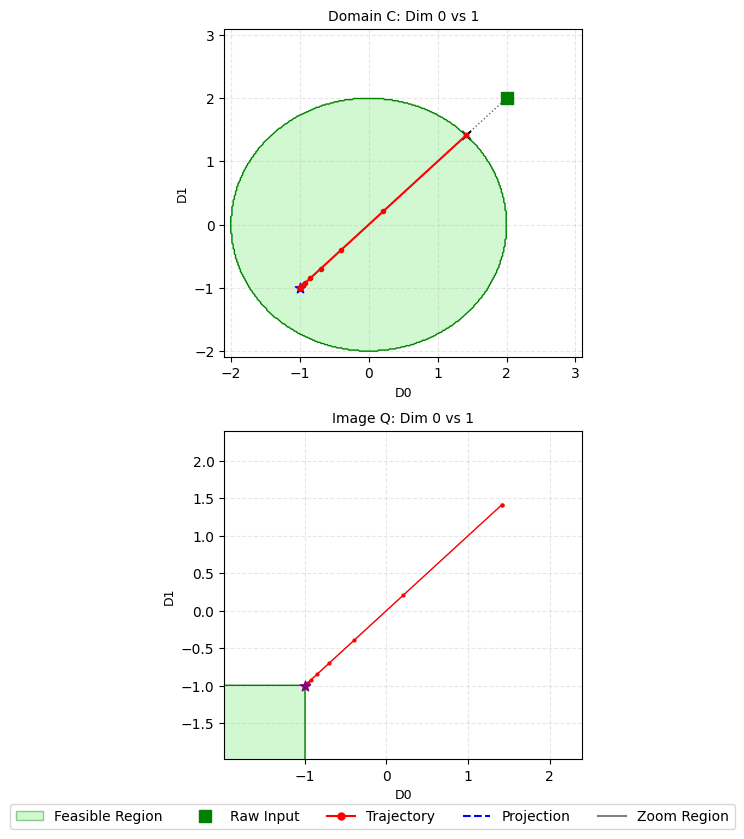

In [4]:
_ = visualize_complete_system(
    x_hist, f_hist, z_proj_hist,
    cons_C, cons_Qplus,
    x0=x_init,   
)

In [44]:
# ==========================================
# 3. GIẢI CẤP 2 (TỐI ƯU HÓA TRÊN MIỀN RÀNG BUỘC)
# ==========================================

u_star = np.array([-0.5, -1.5]) 

# Cấu hình thuật toán
max_iter_2 = 200
eta = 0.1      # Step size cơ bản
beta = 2.0     # Hệ số phạt ban đầu

P_C = prob.proj_C
P_Qplus = prob.proj_Qplus

x_curr = x_feasible.copy()

# --- [ADD] List lưu lịch sử để vẽ ---
path_x = [x_curr.copy()] 

table = PrettyTable()
table.field_names = ["k", "(a, b)", "x_curr", "S(x)", "Viol_C", "Viol_Q+"]

for k in range(max_iter_2):
    # 1. Gradient Mục tiêu
    grad_S = (x_curr - u_star)
    
    # 2. Gradient Phạt Q+
    val_f = x_curr 
    proj_q = P_Qplus(val_f)
    grad_Phi_Q = (val_f - proj_q)
    
    # 3. Gradient Phạt C
    proj_c = P_C(x_curr)
    grad_Phi_C = (x_curr - proj_c)
    
    # Update params
    alpha_k = eta / (1 + 0.1*k)
    beta_k = beta * (1 + 0.05*k)
    
    # Công thức lặp
    grad_total = alpha_k * grad_S + beta_k * (grad_Phi_Q + grad_Phi_C)
    x_next = x_curr - grad_total
    
    # Log & Save
    dist_u = np.linalg.norm(x_curr - u_star)
    viol_c = np.linalg.norm(grad_Phi_C)
    viol_q = np.linalg.norm(grad_Phi_Q)
    
    table.add_row([k,  f"({alpha_k:.3f}, {beta_k:.3f})", np.array2string(x_curr, precision=3),
                   f"{dist_u:.4f}", f"{viol_c:.4f}", f"{viol_q:.4f}"])
    
    # --- [ADD] Lưu điểm mới ---
    path_x.append(x_next.copy())
    x_curr = x_next

print(table)
print(f"-> Kết quả cuối cùng Phase 2: {x_curr}")
print(f"-> Điểm u*: {u_star}")



+-----+-----------------+-----------------+--------+--------+---------+
|  k  |      (a, b)     |      x_curr     |  S(x)  | Viol_C | Viol_Q+ |
+-----+-----------------+-----------------+--------+--------+---------+
|  0  |  (0.100, 2.000) |    [-1. -1.]    | 0.7071 | 0.0000 |  0.0001 |
|  1  |  (0.091, 2.100) |  [-0.95 -1.05]  | 0.6364 | 0.0000 |  0.0500 |
|  2  |  (0.083, 2.200) | [-1.014 -1.091] | 0.6569 | 0.0000 |  0.0000 |
|  3  |  (0.077, 2.300) | [-0.971 -1.125] | 0.6022 | 0.0000 |  0.0288 |
|  4  |  (0.071, 2.400) | [-1.001 -1.154] | 0.6091 | 0.0000 |  0.0000 |
|  5  |  (0.067, 2.500) | [-0.965 -1.179] | 0.5656 | 0.0000 |  0.0346 |
|  6  |  (0.062, 2.600) | [-1.021 -1.2  ] | 0.6010 | 0.0000 |  0.0000 |
|  7  |  (0.059, 2.700) | [-0.988 -1.219] | 0.5635 | 0.0000 |  0.0117 |
|  8  |  (0.056, 2.800) | [-0.991 -1.235] | 0.5580 | 0.0000 |  0.0088 |
|  9  |  (0.053, 2.900) | [-0.989 -1.25 ] | 0.5488 | 0.0000 |  0.0115 |
|  10 |  (0.050, 3.000) | [-0.996 -1.263] | 0.5497 | 0.0000 |  0

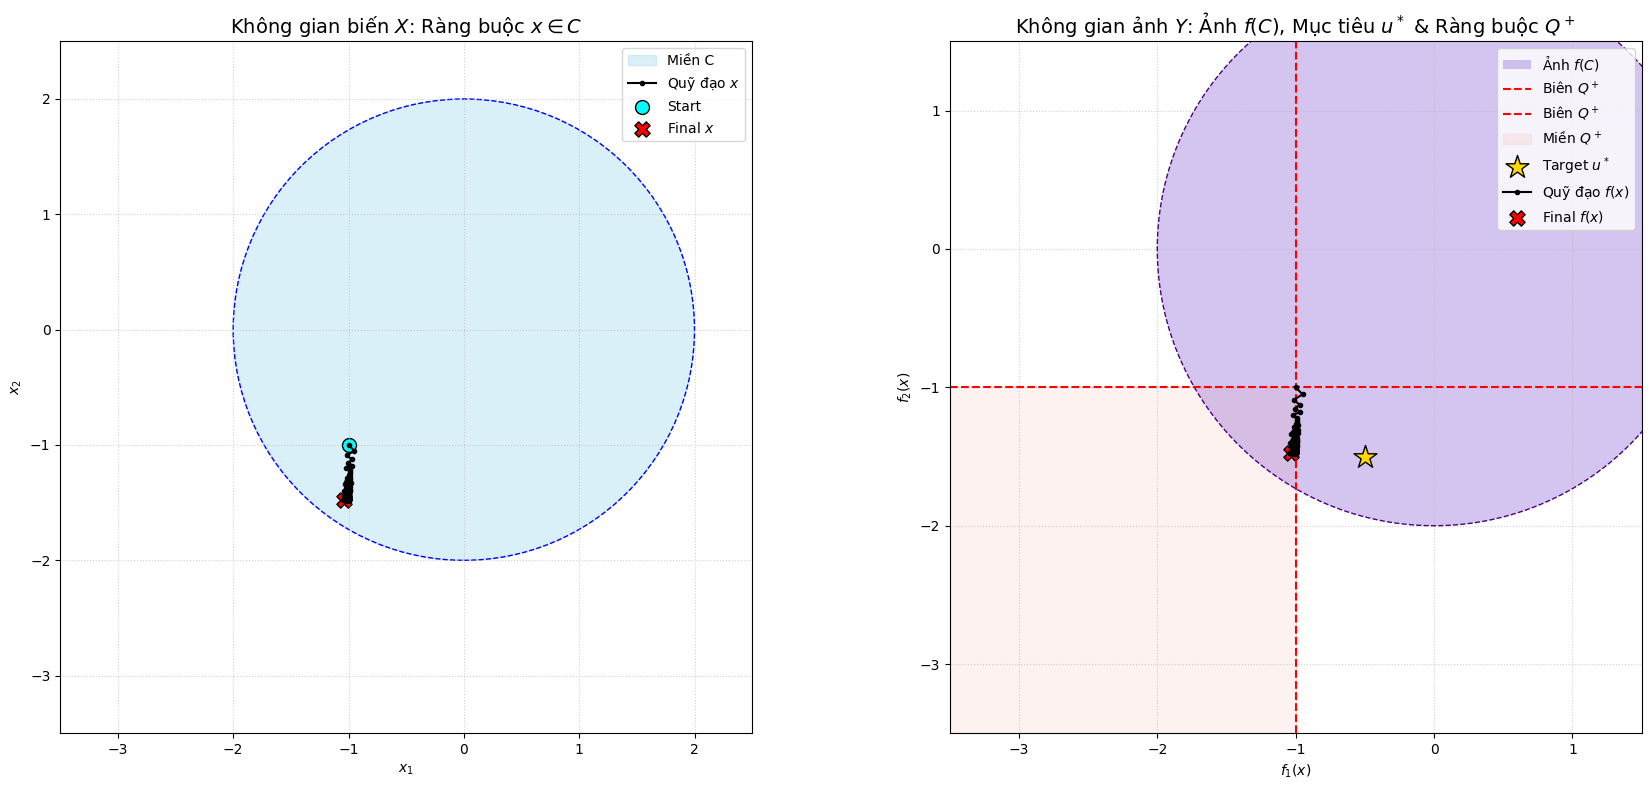

In [45]:
# ==========================================
# 4. PLOTTING (VẼ ĐỒ THỊ VỚI ẢNH f(C))
# ==========================================

# 1. Chuẩn bị dữ liệu quỹ đạo
path_x_arr = np.array(path_x) 
path_f_arr = np.array([prob.objective_func(p) for p in path_x_arr])

# 2. TÍNH TOÁN BIÊN CỦA f(C)
# Tạo các điểm trên biên của C (Hình tròn bán kính 2) để ánh xạ sang bên phải
theta = np.linspace(0, 2*np.pi, 200) # 200 điểm cho mượt
boundary_x = 2 * np.cos(theta)
boundary_y = 2 * np.sin(theta)
boundary_C_points = np.vstack((boundary_x, boundary_y)).T

# Ánh xạ các điểm biên này qua hàm f để có biên của f(C)
boundary_fC_points = np.array([prob.objective_func(p) for p in boundary_C_points])

# 3. Khởi tạo khung hình
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# ---------------------------------------------------------
# HÌNH 1: KHÔNG GIAN BIẾN X (Tập C và quỹ đạo x)
# ---------------------------------------------------------
ax1.set_title("Không gian biến $X$: Ràng buộc $x \\in C$", fontsize=14)

# Vẽ Tập C (Hình tròn bán kính 2)
circle = plt.Circle((0, 0), 2, color='skyblue', alpha=0.3, label='Miền C')
ax1.add_patch(circle)
ax1.add_patch(plt.Circle((0, 0), 2, color='blue', fill=False, linestyle='--')) # Viền

# Vẽ quỹ đạo x
ax1.plot(path_x_arr[:, 0], path_x_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $x$')
ax1.scatter(path_x_arr[0, 0], path_x_arr[0, 1], c='cyan', s=100, edgecolors='k', label='Start')
ax1.scatter(path_x_arr[-1, 0], path_x_arr[-1, 1], c='red', s=120, marker='X', edgecolors='k', label='Final $x$')

# Trang trí Ax1
ax1.set_xlim(-3.5, 2.5)
ax1.set_ylim(-3.5, 2.5)
ax1.set_aspect('equal')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.legend(loc='upper right')

# ---------------------------------------------------------
# HÌNH 2: KHÔNG GIAN ẢNH Y (Ảnh f(C), Q+ và quỹ đạo f(x))
# ---------------------------------------------------------
ax2.set_title("Không gian ảnh $Y$: Ảnh $f(C)$, Mục tiêu $u^*$ & Ràng buộc $Q^+$", fontsize=14)

# --- [THAY ĐỔI Ở ĐÂY] VẼ TẬP ẢNH f(C) ---
# Dùng Polygon để tô màu vùng f(C)
poly_fC = plt.Polygon(boundary_fC_points, closed=True, facecolor='mediumpurple', alpha=0.4, label='Ảnh $f(C)$')
ax2.add_patch(poly_fC)
# Vẽ đường viền của f(C)
ax2.plot(boundary_fC_points[:, 0], boundary_fC_points[:, 1], color='indigo', linestyle='--', linewidth=1)

# Vẽ biên giới hạn của Q+
ax2.axvline(x=-1, color='red', linestyle='--', linewidth=1.5, label='Biên $Q^+$')
ax2.axhline(y=-1, color='red', linestyle='--', linewidth=1.5, label='Biên $Q^+$')

# Tô màu vùng Q+ (Vùng khả thi của f(x))
rect_Qplus = patches.Rectangle((-5, -5), 4, 4, color='salmon', alpha=0.1, label='Miền $Q^+$')
ax2.add_patch(rect_Qplus)

# Vẽ điểm mục tiêu u* (Target)
ax2.scatter(u_star[0], u_star[1], c='gold', s=300, marker='*', edgecolors='k', zorder=10, label='Target $u^*$')

# Vẽ quỹ đạo f(x)
ax2.plot(path_f_arr[:, 0], path_f_arr[:, 1], 'k.-', linewidth=1.5, label='Quỹ đạo $f(x)$')
ax2.scatter(path_f_arr[-1, 0], path_f_arr[-1, 1], c='red', s=120, marker='X', edgecolors='k', label='Final $f(x)$')

# Trang trí Ax2
ax2.set_xlim(-3.5, 1.5)
ax2.set_ylim(-3.5, 1.5)
ax2.set_aspect('equal')
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.set_xlabel("$f_1(x)$")
ax2.set_ylabel("$f_2(x)$")
ax2.legend(loc='upper right')

plt.tight_layout()
plt.show()

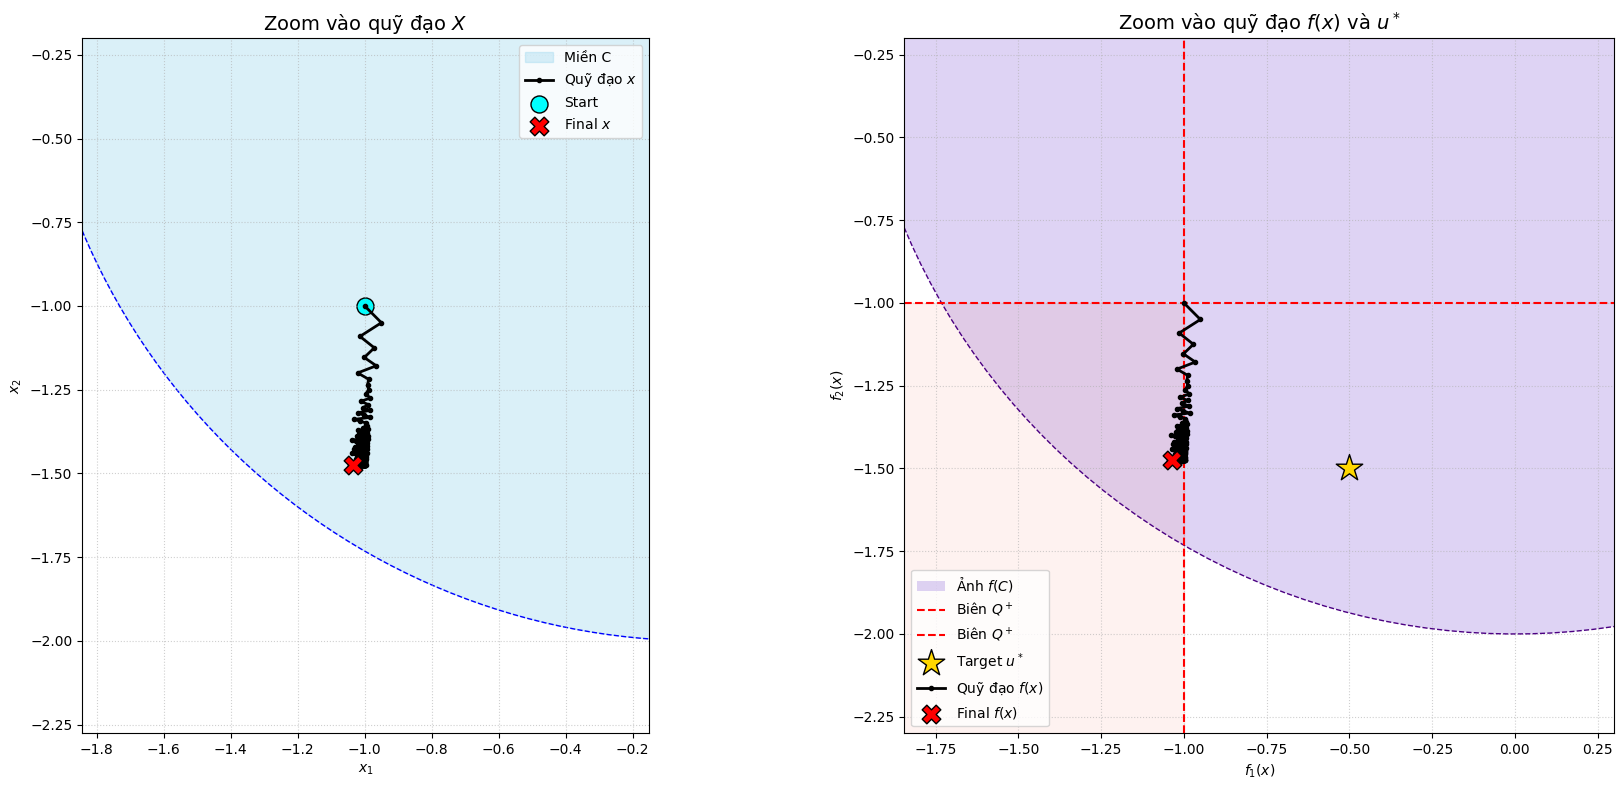

In [46]:
# ==========================================
# 4. PLOTTING 
# ==========================================

# 1. Chuẩn bị dữ liệu
path_x_arr = np.array(path_x) 
path_f_arr = np.array([prob.objective_func(p) for p in path_x_arr])

# 2. Tạo biên f(C) cho hình vẽ bên phải
theta = np.linspace(0, 2*np.pi, 200)
boundary_C_points = np.vstack((2 * np.cos(theta), 2 * np.sin(theta))).T
boundary_fC_points = np.array([prob.objective_func(p) for p in boundary_C_points])

# 3. Khởi tạo hình
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))

# --- CẤU HÌNH ZOOM (QUAN TRỌNG) ---
# Tính toán giới hạn dựa trên dữ liệu thực tế để phóng to
margin = 0.8  # Khoảng cách từ điểm xa nhất đến mép hình (giảm số này để zoom to hơn)

# [Tính Box cho Hình 1] Dựa trên quỹ đạo x
min_x1, max_x1 = np.min(path_x_arr[:, 0]), np.max(path_x_arr[:, 0])
min_y1, max_y1 = np.min(path_x_arr[:, 1]), np.max(path_x_arr[:, 1])

# [Tính Box cho Hình 2] Dựa trên quỹ đạo f(x) + Target u* + Góc Q+(-1,-1)
all_fx = np.concatenate([path_f_arr[:, 0], [u_star[0]], [-1]])
all_fy = np.concatenate([path_f_arr[:, 1], [u_star[1]], [-1]])
min_x2, max_x2 = np.min(all_fx), np.max(all_fx)
min_y2, max_y2 = np.min(all_fy), np.max(all_fy)

# ---------------------------------------------------------
# HÌNH 1: KHÔNG GIAN BIẾN X
# ---------------------------------------------------------
ax1.set_title("Zoom vào quỹ đạo $X$", fontsize=14)

# Vẽ Tập C
circle = plt.Circle((0, 0), 2, color='skyblue', alpha=0.3, label='Miền C')
ax1.add_patch(circle)
ax1.add_patch(plt.Circle((0, 0), 2, color='blue', fill=False, linestyle='--'))

# Vẽ quỹ đạo
ax1.plot(path_x_arr[:, 0], path_x_arr[:, 1], 'k.-', linewidth=2, label='Quỹ đạo $x$') # Tăng độ dày line
ax1.scatter(path_x_arr[0, 0], path_x_arr[0, 1], c='cyan', s=150, edgecolors='k', label='Start')
ax1.scatter(path_x_arr[-1, 0], path_x_arr[-1, 1], c='red', s=180, marker='X', edgecolors='k', zorder=5, label='Final $x$')

# Cài đặt giới hạn (Zoom)
ax1.set_xlim(min_x1 - margin, max_x1 + margin)
ax1.set_ylim(min_y1 - margin, max_y1 + margin)
ax1.set_aspect('equal')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.set_xlabel("$x_1$")
ax1.set_ylabel("$x_2$")
ax1.legend(loc='upper right')

# ---------------------------------------------------------
# HÌNH 2: KHÔNG GIAN ẢNH Y
# ---------------------------------------------------------
ax2.set_title("Zoom vào quỹ đạo $f(x)$ và $u^*$", fontsize=14)

# Vẽ f(C)
poly_fC = plt.Polygon(boundary_fC_points, closed=True, facecolor='mediumpurple', alpha=0.3, label='Ảnh $f(C)$')
ax2.add_patch(poly_fC)
ax2.plot(boundary_fC_points[:, 0], boundary_fC_points[:, 1], color='indigo', linestyle='--', linewidth=1)

# Vẽ biên Q+
ax2.axvline(x=-1, color='red', linestyle='--', linewidth=1.5, label='Biên $Q^+$')
ax2.axhline(y=-1, color='red', linestyle='--', linewidth=1.5, label='Biên $Q^+$')
# Tô màu Q+
rect_Qplus = patches.Rectangle((-10, -10), 9, 9, color='salmon', alpha=0.1) # Vẽ to ra để phủ kín background
ax2.add_patch(rect_Qplus)

# Vẽ Target u*
ax2.scatter(u_star[0], u_star[1], c='gold', s=400, marker='*', edgecolors='k', zorder=10, label='Target $u^*$')

# Vẽ quỹ đạo f(x)
ax2.plot(path_f_arr[:, 0], path_f_arr[:, 1], 'k.-', linewidth=2, label='Quỹ đạo $f(x)$')
ax2.scatter(path_f_arr[-1, 0], path_f_arr[-1, 1], c='red', s=180, marker='X', edgecolors='k', zorder=5, label='Final $f(x)$')

# Cài đặt giới hạn (Zoom)
ax2.set_xlim(min_x2 - margin, max_x2 + margin)
ax2.set_ylim(min_y2 - margin, max_y2 + margin)
ax2.set_aspect('equal')
ax2.grid(True, linestyle=':', alpha=0.6)
ax2.set_xlabel("$f_1(x)$")
ax2.set_ylabel("$f_2(x)$")
ax2.legend(loc='lower left') # Đổi vị trí legend để đỡ che hình

plt.tight_layout()
plt.show()

* Chọn tham số $\beta_k$
* Điều kiện dừng

# Khảo sát

* liệt kê kịch bản 
* **các dãy đảm bảo hội tụ**
* sau đó mới đến các case khác, tổng quát hơn

---